In [1]:
%matplotlib inline
import pyfolio as pf

In [2]:
import zipline
from zipline.api import *
from zipline.utils.events import BeforeClose
from zipline.utils.run_algo import run_algorithm
from datetime import datetime
import pytz
import pandas as pd
import pandas_datareader.data as web

In [3]:
!zipline bundles

quandl 2017-09-27 13:50:20.349308
quantopian-quandl 2017-09-27 13:49:19.623490
quantopian-quandl 2017-09-27 10:45:08.190035


In [4]:
candles = 3
ticker = 'SPY'
from_date = datetime(2000,1,1, tzinfo=pytz.utc)
to_date = datetime(2014,1,1, tzinfo=pytz.utc)
capital_base = 10000

In [5]:
def initialize(context):
    context.i = 0
    context.asset = symbol(ticker)
    schedule_function(func = handle_date_eod,
                  date_rule = date_rules.every_day(),
                  time_rule = BeforeClose(minutes=30),
                  calendar = calendars.US_EQUITIES)

def handle_date_eod(context, data):
    context.i += 1
    if context.i < candles:
        return

    #always close previous day
    order_target_percent(context.asset, 0)

    hist = data.history(context.asset, 
                           ('open', 'high', 'low', 'close'), 
                           bar_count=candles, 
                           frequency="1d")
    current_candle = hist.iloc[-1]
    
    all_negative = ((hist['close'] - hist['open']) < 0).all()
    if all_negative:
        #current_candle = hist.iloc[-1]
        lower_bound = current_candle['low'] + (current_candle['high']-current_candle['low'])*0.75
        if current_candle['close'] > lower_bound:
            act_price = data.current(context.asset, 'price')
            print(hist)
            order_target_percent(context.asset, 10) #, stop_price=close_price
            record(history=hist)
def handle_data(context, data):
    pass

In [6]:
def load_data(ticker, from_date, to_date):
    from collections import OrderedDict
    data = OrderedDict()
    
    df = web.DataReader(ticker, 'yahoo', from_date, to_date)
    df.dropna(inplace=True)
    df.drop(['Adj Close'], axis=1, inplace=True)
    
    data[ticker] = df
    panel = pd.Panel(data)
    panel.minor_axis = ['open', 'high', 'low', 'close', 'volume']
    panel.major_axis = panel.major_axis.tz_localize(pytz.utc)

    return panel

In [7]:
spy_df = load_data('SPY', from_date, to_date)

In [8]:
results = run_algorithm(from_date, 
                        to_date,
                        initialize,
                        capital_base,
                        handle_data=handle_data,
                        data=spy_df    
                       )

/usr/local/lib/python3.4/site-packages/empyrical/stats.py:522: RuntimeWarning: invalid value encountered in double_scalars
  sortino = mu / dsr


Price: 139.5
                             close     high      low     open
2000-02-10 00:00:00+00:00  141.562  142.562  140.875  141.625
2000-02-11 00:00:00+00:00  138.688  141.938  138.031  141.844
2000-02-14 00:00:00+00:00  139.500  139.781  138.312  139.781
Price: 125.809998
                            close    high     low    open
2001-02-20 00:00:00+00:00  128.39  131.14  128.10  131.04
2001-02-21 00:00:00+00:00  125.62  128.84  125.50  127.90
2001-02-22 00:00:00+00:00  125.81  126.54  123.02  126.35
Price: 124.959999
                            close    high     low    open
2001-02-21 00:00:00+00:00  125.62  128.84  125.50  127.90
2001-02-22 00:00:00+00:00  125.81  126.54  123.02  126.35
2001-02-23 00:00:00+00:00  124.96  125.54  121.80  125.08
Price: 145.880005
                            close    high     low    open
2007-12-14 00:00:00+00:00  147.17  149.10  147.10  147.93
2007-12-17 00:00:00+00:00  145.07  146.87  144.86  146.61
2007-12-18 00:00:00+00:00  145.88  146.48  143.

In [9]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [10]:
returns[-5:]

2013-12-24 00:00:00+00:00    0.0
2013-12-26 00:00:00+00:00    0.0
2013-12-27 00:00:00+00:00    0.0
2013-12-30 00:00:00+00:00    0.0
2013-12-31 00:00:00+00:00    0.0
Name: returns, dtype: float64

In [11]:
len(positions)*2-len(transactions)

0

In [12]:
positions

,Equity(0 [SPY]),cash
index,,
2000-02-15 00:00:00+00:00,101011.915304,-91017.285346
2001-02-23 00:00:00+00:00,84347.999325,-75851.717246
2001-02-26 00:00:00+00:00,510.480012,9775.242237
2007-12-19 00:00:00+00:00,102699.523520,-92424.801275
2007-12-21 00:00:00+00:00,110060.593715,-99149.045378
2010-05-18 00:00:00+00:00,115547.202056,-103831.642909
2012-12-28 00:00:00+00:00,109223.399220,-98179.320074


In [13]:
transactions

,amount,commission,dt,order_id,price,sid,symbol,txn_dollars
2000-02-15 21:00:00+00:00,716,None,2000-02-15 21:00:00+00:00,f1c7091b7fd346cbbe00884f47dbcd1c,141.078094,Equity(0 [SPY]),Equity(0 [SPY]),-101011.915346
2000-02-16 21:00:00+00:00,-716,None,2000-02-16 21:00:00+00:00,b5eb17c56cea465aa4f744740e2d733a,139.000000,Equity(0 [SPY]),Equity(0 [SPY]),99523.999935
2001-02-23 21:00:00+00:00,675,None,2001-02-23 21:00:00+00:00,35d7b1c7c45047f8b410343c6c358a54,124.959999,Equity(0 [SPY]),Equity(0 [SPY]),-84347.999334
2001-02-26 21:00:00+00:00,-675,None,2001-02-26 21:00:00+00:00,57fe72c8efbf412fad80120eb675edcf,127.620003,Equity(0 [SPY]),Equity(0 [SPY]),86143.501995
2001-02-26 21:00:00+00:00,4,None,2001-02-26 21:00:00+00:00,31f2cb85e56540a8bdaae8265c7052bb,127.620003,Equity(0 [SPY]),Equity(0 [SPY]),-510.480012
2001-02-27 21:00:00+00:00,-4,None,2001-02-27 21:00:00+00:00,471c3492d6304639a771fdcfda3b0d61,126.440002,Equity(0 [SPY]),Equity(0 [SPY]),505.760008
2007-12-19 21:00:00+00:00,704,None,2007-12-19 21:00:00+00:00,6aa546a962b744a89a6aaab27b6af80d,145.880005,Equity(0 [SPY]),Equity(0 [SPY]),-102699.523520
2007-12-20 21:00:00+00:00,-704,None,2007-12-20 21:00:00+00:00,97e2d4c5e03346248b1eccd1582f3935,146.800003,Equity(0 [SPY]),Equity(0 [SPY]),103347.202112
2007-12-21 21:00:00+00:00,743,None,2007-12-21 21:00:00+00:00,260f51155de1417390877a0274b1d9b7,148.130005,Equity(0 [SPY]),Equity(0 [SPY]),-110060.593715
2007-12-24 18:00:00+00:00,-743,None,2007-12-24 18:00:00+00:00,bc783de2c5984542b4b03093bdf7e893,149.229996,Equity(0 [SPY]),Equity(0 [SPY]),110877.887025


In [14]:
results.history['2000-02-15 ']

,close,high,low,open
2000-02-10 00:00:00+00:00,141.562,142.562,140.875,141.625
2000-02-11 00:00:00+00:00,138.688,141.938,138.031,141.844
2000-02-14 00:00:00+00:00,139.500,139.781,138.312,139.781


Entire data start date: 2000-01-03
Entire data end date: 2013-12-31
Backtest months: 167


/usr/local/lib/python3.4/site-packages/empyrical/stats.py:954: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


,Backtest
Annual return,1.8%
Cumulative returns,28.9%
Annual volatility,8.8%
Sharpe ratio,0.25
Calmar ratio,0.12
Stability,0.66
Max drawdown,-15.0%
Omega ratio,2.45
Sortino ratio,0.51
Skew,18.81


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.04,2000-02-14,2001-02-23,2001-02-26,271
1,5.79,2010-05-17,2012-12-28,2012-12-31,686
2,0.11,2001-02-26,2007-12-19,2007-12-20,1779
3,0.05,2007-12-20,2007-12-21,2007-12-24,3
4,0.00,2000-01-03,2000-01-03,2000-01-03,1


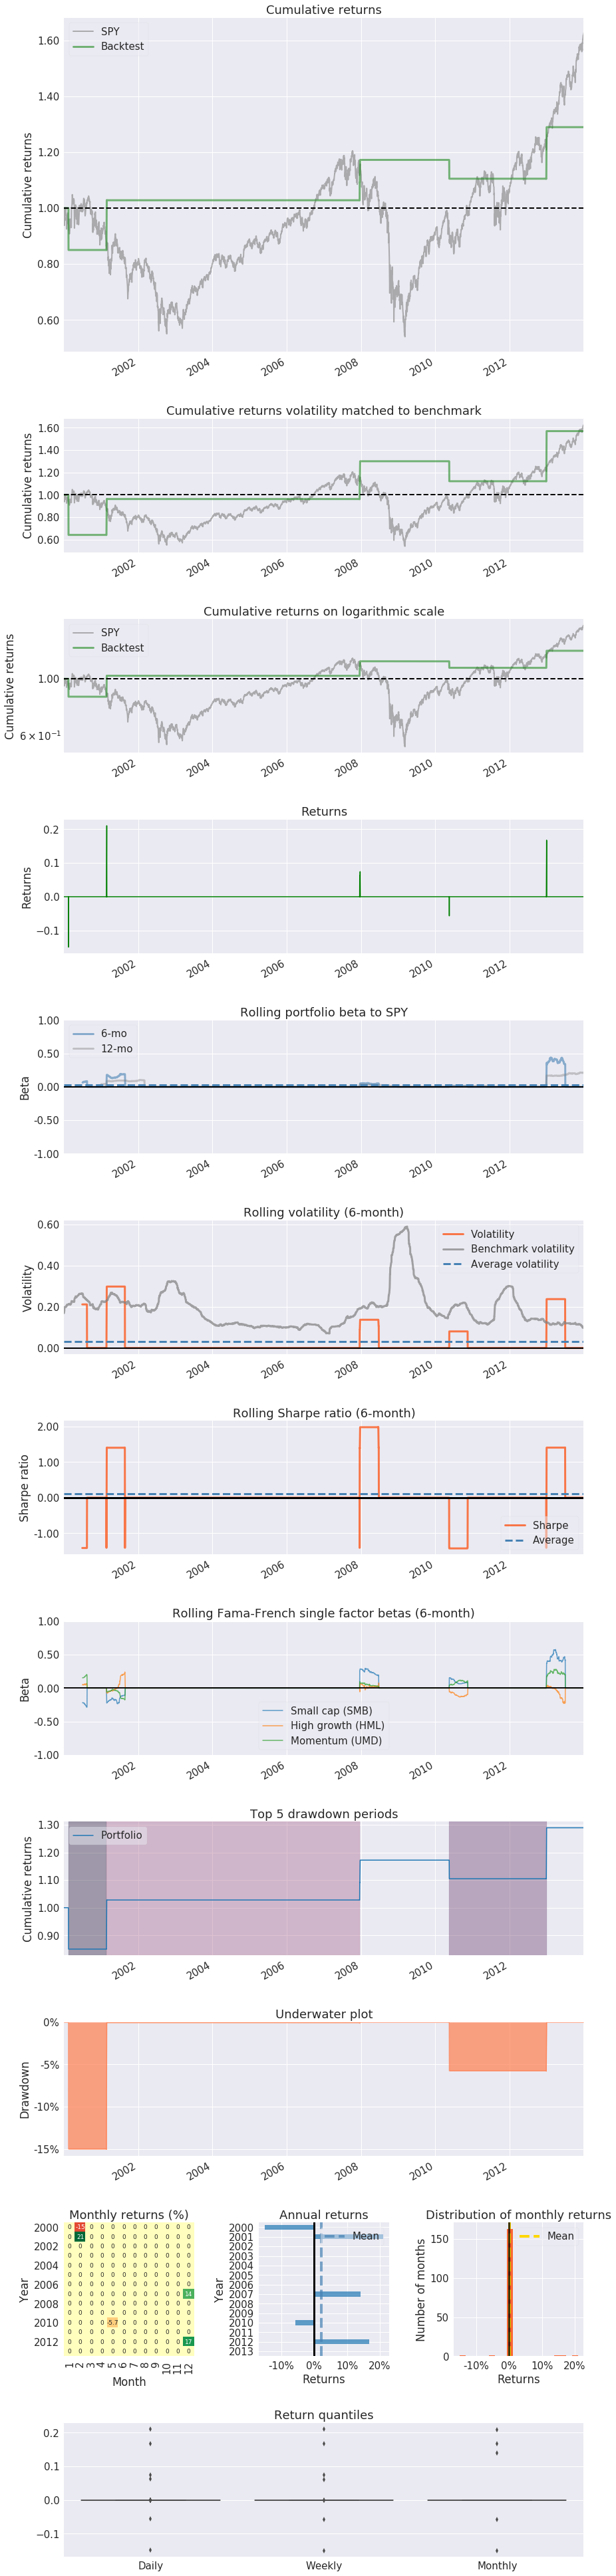

Stress Events,mean,min,max
Dotcom,0.00%,0.00%,0.00%
Lehmann,0.00%,0.00%,0.00%
9/11,0.00%,0.00%,0.00%
US downgrade/European Debt Crisis,0.00%,0.00%,0.00%
Fukushima,0.00%,0.00%,0.00%
US Housing,0.00%,0.00%,0.00%
EZB IR Event,0.00%,0.00%,0.00%
Aug07,0.00%,0.00%,0.00%
Mar08,0.00%,0.00%,0.00%
Sept08,0.00%,0.00%,0.00%


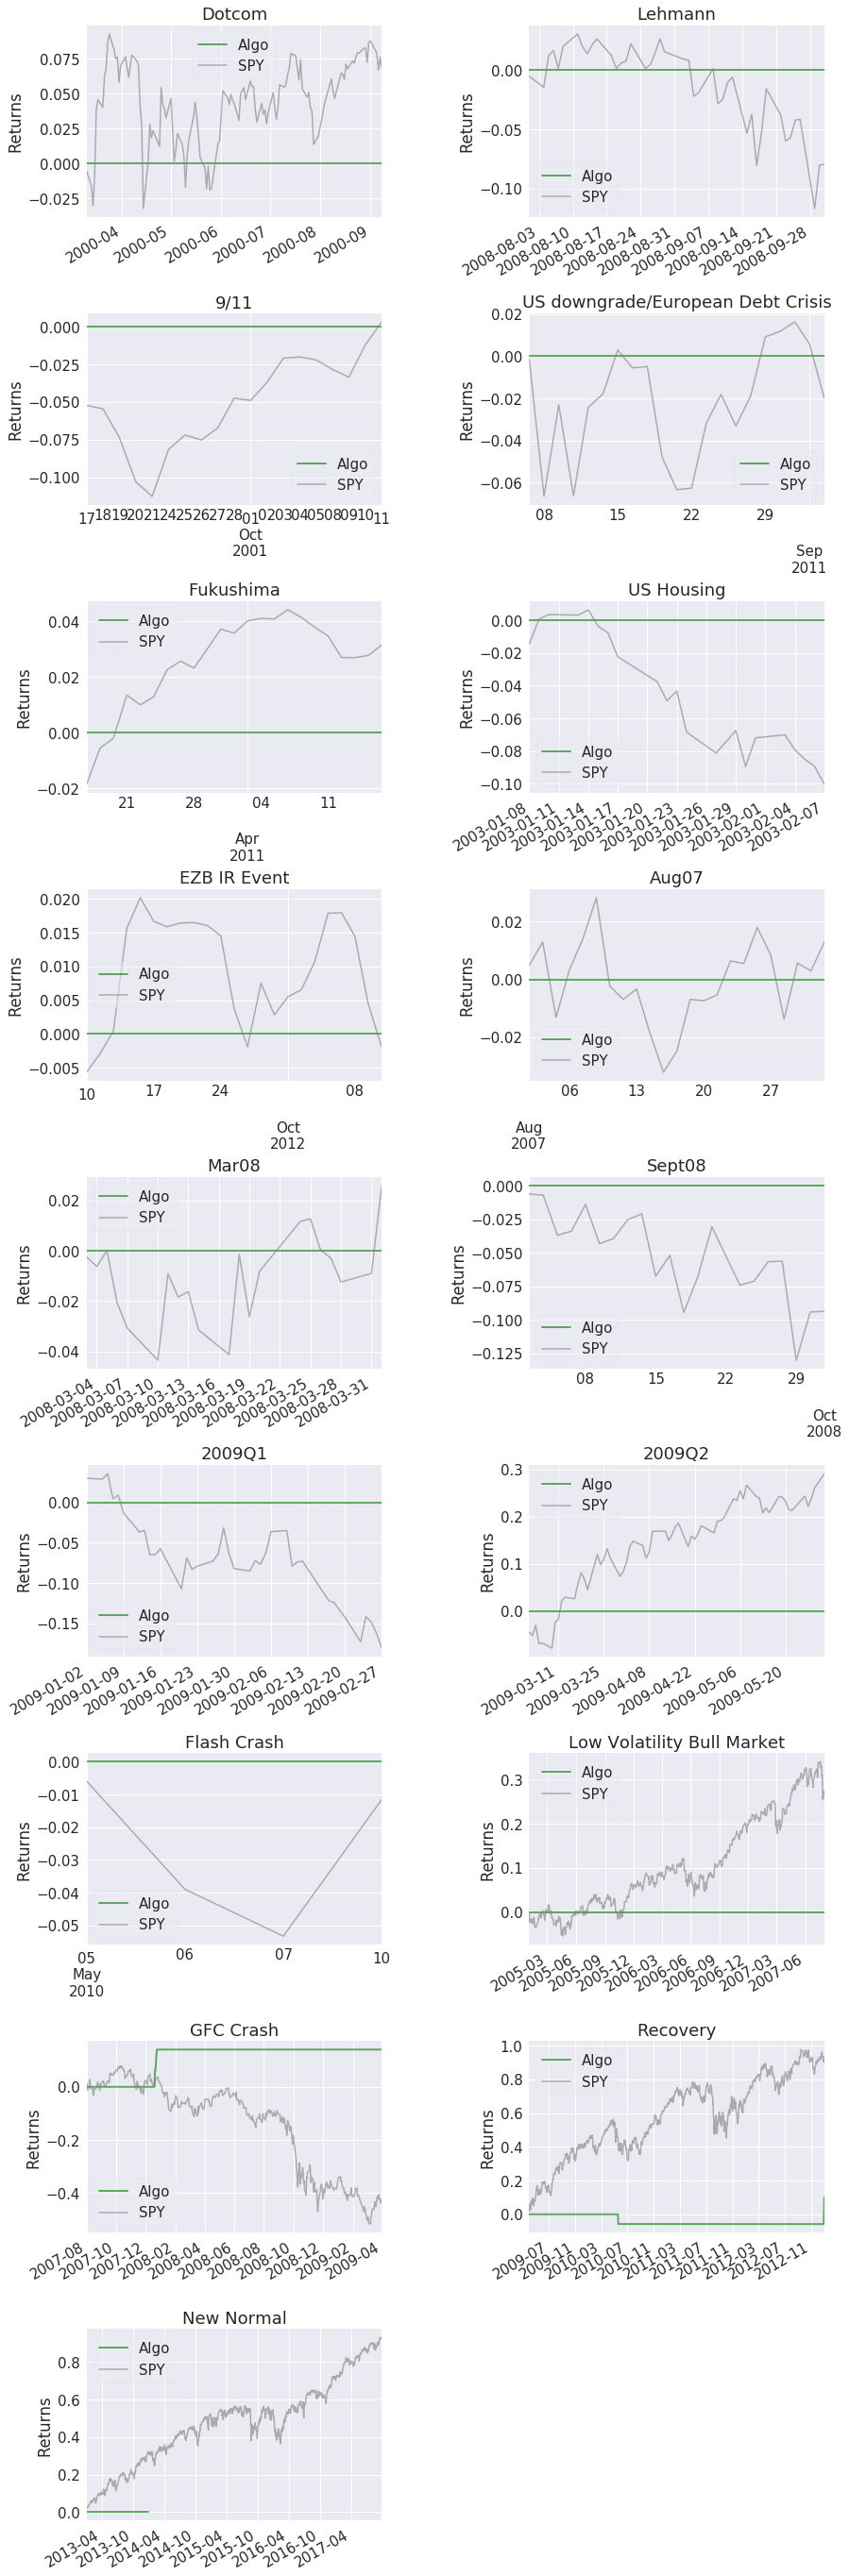

Top 10 long positions of all time,max
SPY,1010.66%


Top 10 short positions of all time,max


Top 10 positions of all time,max
SPY,1010.66%


All positions ever held,max
SPY,1010.66%


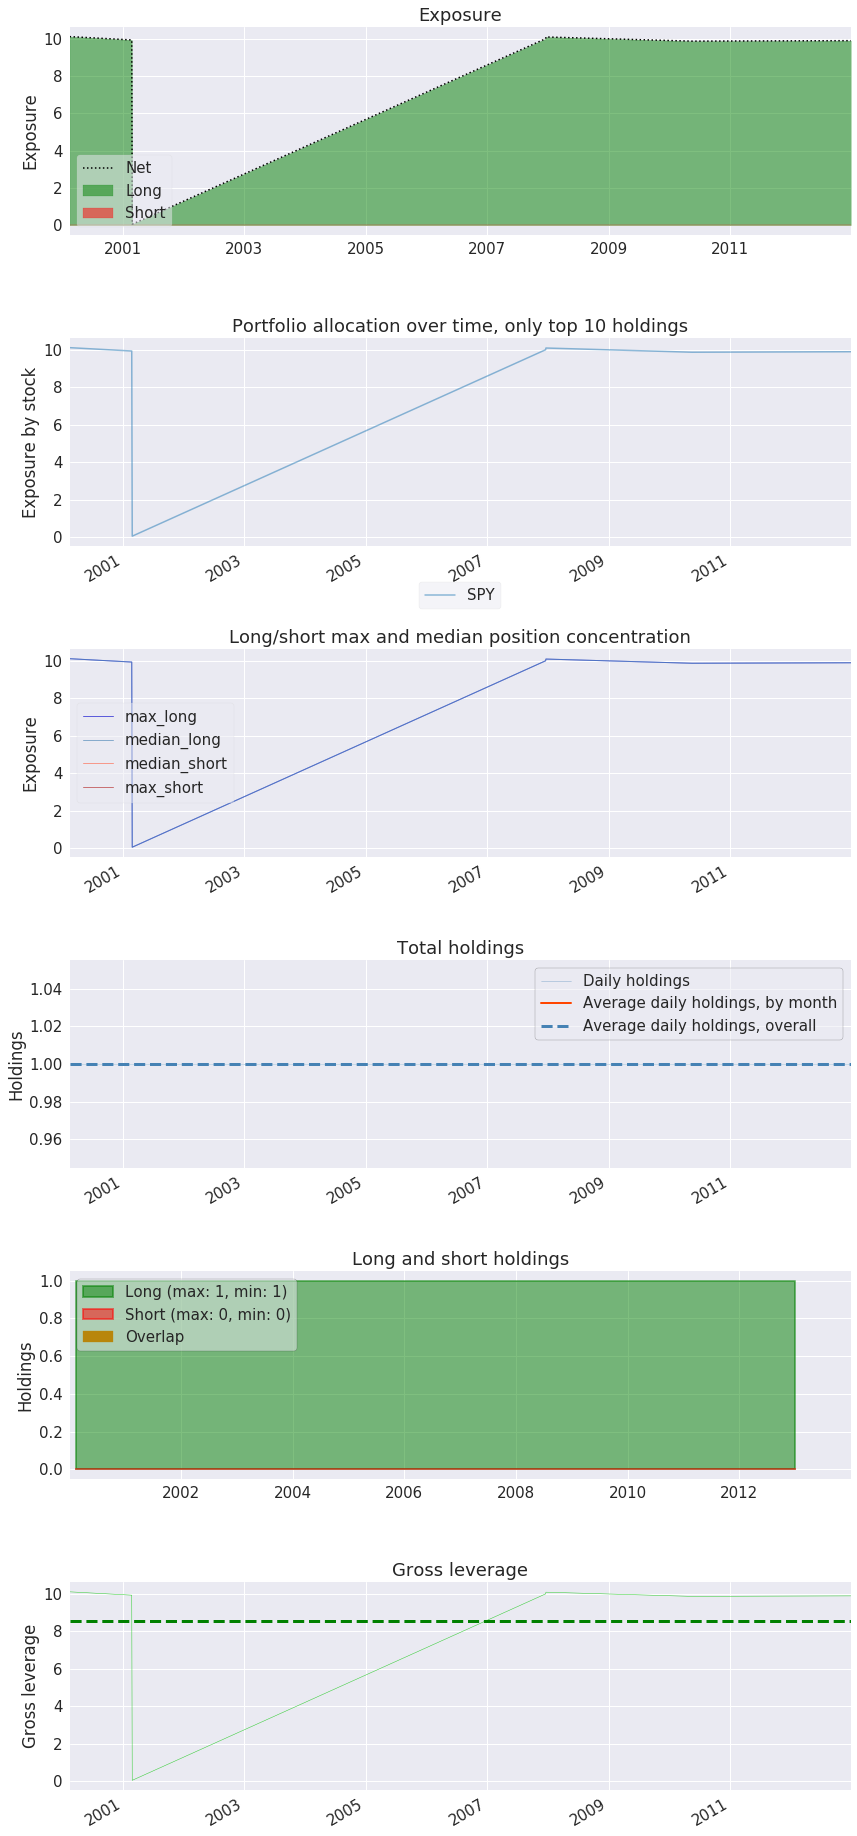

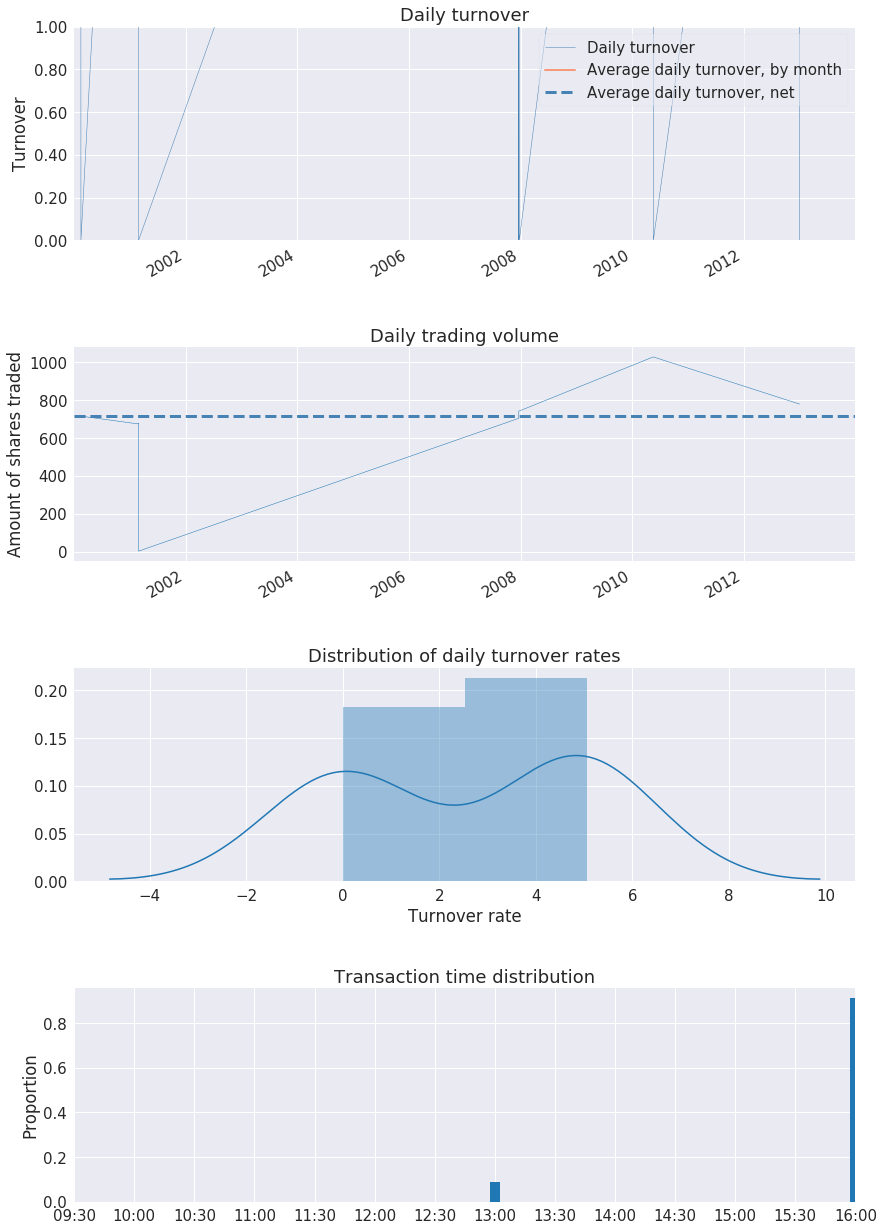

/usr/local/lib/python3.4/site-packages/pyfolio/round_trips.py:309: RuntimeWarning: divide by zero encountered in double_scalars
  ending_price = ending_val / ending_amount


Summary stats,All trades,Long trades
Total number of round_trips,7.00,7.00
Percent profitable,0.57,0.57
Winning round_trips,4.00,4.00
Losing round_trips,3.00,3.00
Even round_trips,0.00,0.00


PnL stats,All trades,Long trades
Total profit,$2966.32,$2966.32
Gross profit,$5116.88,$5116.88
Gross loss,$-2150.56,$-2150.56
Profit factor,$2.38,$2.38
Avg. trade net profit,$423.76,$423.76
Avg. winning trade,$1279.22,$1279.22
Avg. losing trade,$-716.85,$-716.85
Ratio Avg. Win:Avg. Loss,$1.78,$1.78
Largest winning trade,$1856.40,$1856.40
Largest losing trade,$-1487.92,$-1487.92


Duration stats,All trades,Long trades
Avg duration,1 days 20:08:34.285714,1 days 20:08:34.285714
Median duration,1 days 00:00:00,1 days 00:00:00
Longest duration,3 days 00:00:00,3 days 00:00:00
Shortest duration,1 days 00:00:00,1 days 00:00:00


Return stats,All trades,Long trades
Avg returns all round_trips,21.13%,21.13%
Avg returns winning,21.13%,21.13%
Avg returns losing,nan%,nan%
Median returns all round_trips,21.13%,21.13%
Median returns winning,21.13%,21.13%
Median returns losing,nan%,nan%
Largest winning trade,21.13%,21.13%
Largest losing trade,21.13%,21.13%


Symbol stats,SPY
Avg returns all round_trips,21.13%
Avg returns winning,21.13%
Avg returns losing,nan%
Median returns all round_trips,21.13%
Median returns winning,21.13%
Median returns losing,nan%
Largest winning trade,21.13%
Largest losing trade,21.13%


Profitability (PnL / PnL total) per name,
SPY,100.00%


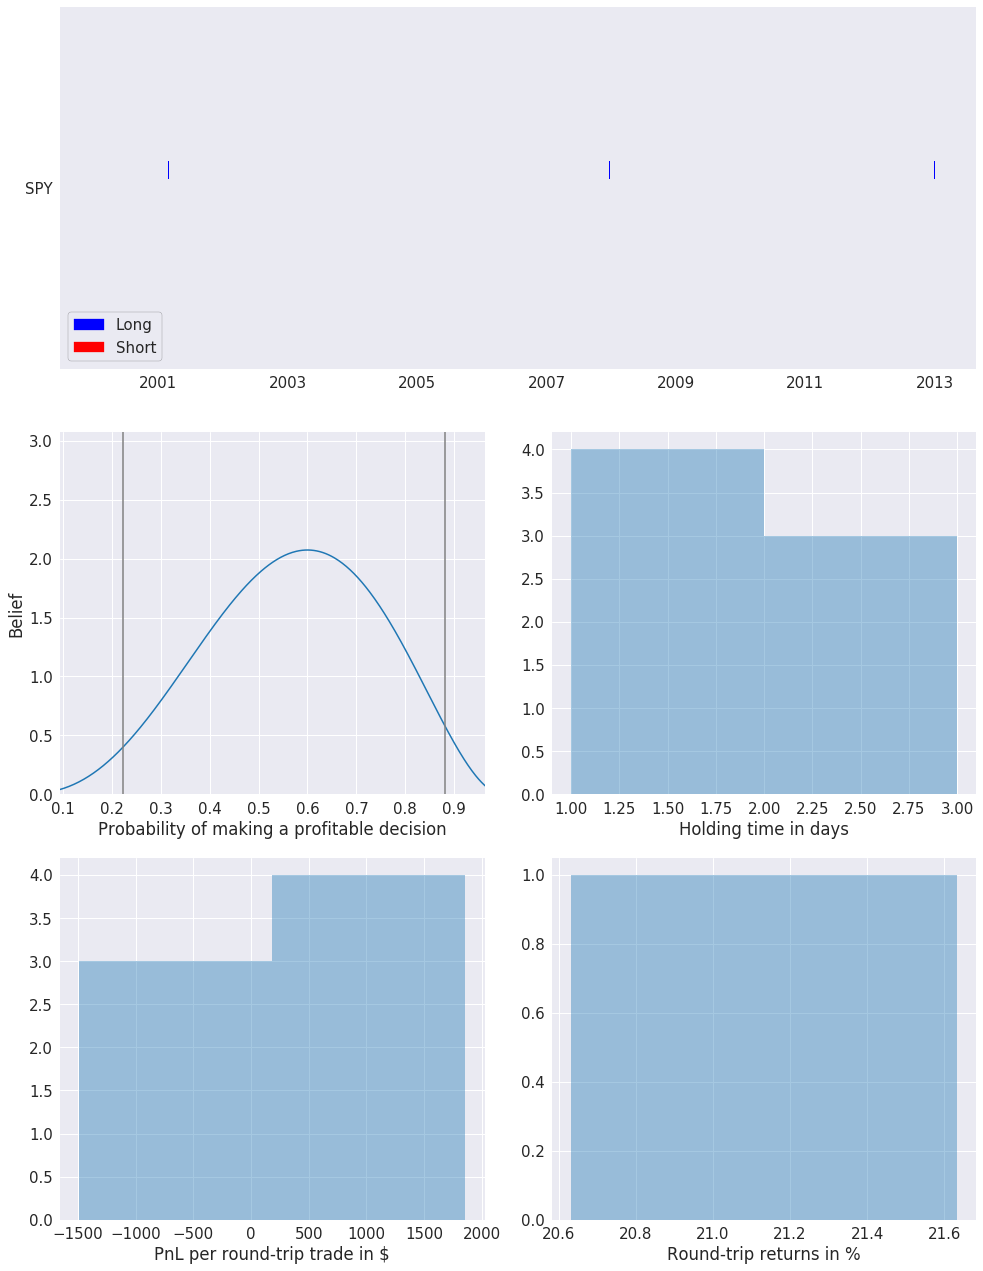

In [15]:
pf.create_full_tear_sheet(returns, positions, transactions, round_trips=True)